# Baseline Model

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import joblib
import warnings 
warnings.filterwarnings('ignore')

Gerekli kütüphaneleri yükledim ve uyarıları kapattım.

In [ ]:
# PUBG veri setini yükleme
train = pd.read_csv('/kaggle/input/pubg-finish-placement-prediction/train_V2.csv')

print(f"Veri seti şekli: {train.shape}")
print(train.head())

# Eksik değer kontrolü
print(train.isnull().sum())

Veri seti şekli: (4446966, 29)
               Id         groupId         matchId  assists  boosts  \
0  7f96b2f878858a  4d4b580de459be  a10357fd1a4a91        0       0   
1  eef90569b9d03c  684d5656442f9e  aeb375fc57110c        0       0   
2  1eaf90ac73de72  6a4a42c3245a74  110163d8bb94ae        1       0   
3  4616d365dd2853  a930a9c79cd721  f1f1f4ef412d7e        0       0   
4  315c96c26c9aac  de04010b3458dd  6dc8ff871e21e6        0       0   

   damageDealt  DBNOs  headshotKills  heals  killPlace  ...  revives  \
0         0.00      0              0      0         60  ...        0   
1        91.47      0              0      0         57  ...        0   
2        68.00      0              0      0         47  ...        0   
3        32.90      0              0      0         75  ...        0   
4       100.00      0              0      0         45  ...        0   

   rideDistance  roadKills  swimDistance  teamKills vehicleDestroys  \
0        0.0000          0          0.00    

* Bu hücrede PUBG veri setini yükledim, boyutunu ve ilk birkaç satırını görüntüledim.
* Eksik değer kontrolünde sadece winPlacePerc sütununda 1 eksik değer olduğunu gördüm.

In [3]:
train = train.dropna(subset=['winPlacePerc'])
print(f"Temizlenmiş veri şekli: {train.shape}")

Temizlenmiş veri şekli: (4446965, 29)


Burada yaptığın işlem, eksik değer içeren satırları hedef değişken olan winPlacePerc sütunundan temizlemek. Yani sadece eksik winPlacePerc olan 1 satır düşürülmüş oldu.

In [4]:
numerical_features = ['kills', 'damageDealt', 'walkDistance', 'rideDistance', 'weaponsAcquired']
categorical_features = ['matchType']

features = numerical_features + categorical_features
X = train[features]
y = train['winPlacePerc']

Burada yaptığım işlemle modelde kullanılacak özellikleri (features) ve hedef değişkeni (target) belirledim.

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Eğitim seti: {X_train.shape}")
print(f"Doğrulama seti: {X_val.shape}")

Eğitim seti: (3557572, 6)
Doğrulama seti: (889393, 6)


Veriyi %80 eğitim, %20 doğrulama olarak ayırdım; `random_state=42` ile bölme sabitlendi.

In [6]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

Burada sayısal ve kategorik özellikler için eksik değer doldurma ve ölçeklendirme/one-hot encoding işlemlerini pipeline ile hazırladım. Sonra `ColumnTransformer` ile hepsini birleştirdim.


In [7]:
model_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

model_pipeline.fit(X_train, y_train)
print("Model eğitimi tamamlandı.")

Model eğitimi tamamlandı.


Modelini `Pipeline` ile oluşturup, ön işleme ve Linear Regression’ı birleştirdim ve eğitim verisiyle modeli eğittim. Eğitimin tamamlandığını ekrana yazdırdım.

Doğrulama RMSE: 0.1633
Doğrulama R^2: 0.7173


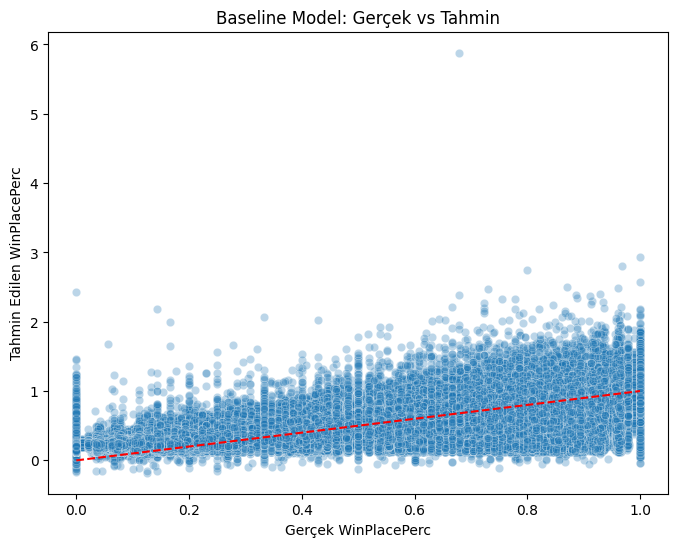

In [8]:
y_val_pred = model_pipeline.predict(X_val)

rmse = mean_squared_error(y_val, y_val_pred, squared=False)
r2 = r2_score(y_val, y_val_pred)

print(f"Doğrulama RMSE: {rmse:.4f}")
print(f"Doğrulama R^2: {r2:.4f}")

plt.figure(figsize=(8,6))
sns.scatterplot(x=y_val, y=y_val_pred, alpha=0.3)
plt.plot([0,1], [0,1], 'r--')  # 45 derece çizgi
plt.xlabel('Gerçek WinPlacePerc')
plt.ylabel('Tahmin Edilen WinPlacePerc')
plt.title('Baseline Model: Gerçek vs Tahmin')
plt.show()

Doğrulama verisiyle modelin tahminlerini yaptım, RMSE ve R² skorlarını hesaplayıp performansı ölçtüm. Grafikle de gerçek ve tahmin edilen değerleri görselleştirerek modelin doğruluğunu gözlemledim.
* Model ortalama %16 hata ile tahmin yapıyor ve verideki varyansın %71’ini açıklayabiliyor.

In [9]:
joblib.dump(model_pipeline, 'pubg_baseline_linear_model.pkl')
print("Model kaydedildi: pubg_baseline_linear_model.pkl")

Model kaydedildi: pubg_baseline_linear_model.pkl


Modeli `pubg_baseline_linear_model.pkl` olarak kaydettim, artık başka notebook veya scriptlerde kolayca yükleyip kullanılabilir.

In [ ]:
regressor = model_pipeline.named_steps['regressor']
preprocessor_features = numerical_features + list(
    model_pipeline.named_steps['preprocessor']
        .named_transformers_['cat']
        .named_steps['onehot']
        .get_feature_names_out(categorical_features)
)

coefficients = regressor.coef_

feature_importance_df = pd.DataFrame({
    'feature': preprocessor_features,
    'coefficient': coefficients
}).sort_values(by='coefficient', key=abs, ascending=False)

print(feature_importance_df)

                       feature  coefficient
13       matchType_normal-solo    -0.256028
14   matchType_normal-solo-fpp    -0.227093
6           matchType_crashtpp     0.206856
5           matchType_crashfpp     0.202150
2                 walkDistance     0.200370
18          matchType_solo-fpp     0.147119
15      matchType_normal-squad    -0.135971
16  matchType_normal-squad-fpp    -0.121575
17              matchType_solo     0.113712
8            matchType_duo-fpp     0.108352
11        matchType_normal-duo    -0.103283
7                matchType_duo     0.096241
12    matchType_normal-duo-fpp    -0.072481
20         matchType_squad-fpp     0.063593
4              weaponsAcquired     0.055080
19             matchType_squad     0.041111
10          matchType_flaretpp    -0.033772
9           matchType_flarefpp    -0.028930
3                 rideDistance     0.025319
1                  damageDealt     0.022647
0                        kills     0.014155


Bu hücrede Linear Regression modelinin feature katsayılarını inceledim. 

Öne çıkanlar:
- `walkDistance`: Daha fazla yürüyen oyuncular genelde daha yüksek WinPlacePerc alıyor.
- `matchType`: Maç türü katsayıları da etkili; bazı türlerde kazanma yüzdesi daha düşük.
- `kills`, `damageDealt`, `weaponsAcquired`: Pozitif ama etkisi daha sınırlı.

**Yürüyüş mesafesi ve maç tipi, kazanmayı belirlemede en güçlü göstergeler.**
